In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.api as sm
%matplotlib notebook

In [2]:
G_Drive = 'C:\\Users\\User\\Google Drive\\'
Dpath = G_Drive+'FishIsland_Outputs/Upscaled_Estimates.csv'

Data = pd.read_csv(Dpath,index_col=['datetime'],parse_dates=['datetime'])
Data = Data.drop(columns=['datetime.1'])
Data.head()

,fch4,fco2,ch4_flux,co2_flux,Air_Temp,Rainfall,wind_speed,Wind_Direction,Net_SW,Net_LW,...,NME_est_FP_m_22,NME_est_FP_m_23,NME_est_FP_m_24,NME_est_FP_m_25,NME_est_FP_m_26,NME_est_FP_m_27,NME_est_FP_m_28,NME_est_FP_m_29,On_Off,On_Off2
datetime,,,,,,,,,,,,,,,,,,,,,
2009-05-01 00:00:00,NaN,NaN,NaN,NaN,-1.0,NaN,2.1,78.0,-2.47,-43.32,...,45.114180,38.099373,39.048203,25.929056,22.222101,33.477745,36.820720,24.224535,NaN,NaN
2009-05-01 01:00:00,NaN,NaN,NaN,NaN,-1.3,NaN,1.9,102.4,-2.58,-40.42,...,45.594364,38.765510,38.692825,27.015213,22.667227,34.126297,36.708720,24.603422,NaN,NaN
2009-05-01 02:00:00,NaN,NaN,NaN,NaN,-1.1,NaN,2.2,154.3,-1.94,-38.93,...,45.684364,38.531950,39.066525,26.696892,21.783482,33.209260,36.433380,24.057219,NaN,NaN
2009-05-01 03:00:00,NaN,NaN,NaN,NaN,-1.4,NaN,2.4,155.8,-1.99,-38.63,...,45.804348,38.259052,39.309720,26.347307,21.149500,32.555416,36.277393,23.673584,NaN,NaN
2009-05-01 04:00:00,NaN,NaN,NaN,NaN,-1.2,NaN,2.0,168.4,-1.84,-35.40,...,46.112270,39.177650,38.875168,27.478960,22.587221,34.035137,36.558342,24.589650,NaN,NaN


# Validation

In [3]:
X = 'fch4'
y = 'NME_est_FP'

# X = 'fco2'
# y = 'NEE_est'

DNA=(Data[[X,y]].dropna())
print('r2',(metrics.r2_score(DNA[X],DNA[y])*100).round(2))
print('RMSE',(metrics.mean_squared_error(DNA[X],DNA[y])**.5).round(2))
print('MAE',(metrics.mean_absolute_error(DNA[X],DNA[y])).round(2))

X2 = sm.add_constant(DNA[X])
est = sm.OLS(DNA[y], X2)
est2 = est.fit()
print(est2.summary())
with open(G_Drive+'PhD_Thesis\\Chapter3_Figs/'+X[0]+'_v_'+y+'_summary.txt', 'w') as fh:
    fh.write(est2.summary().as_text())


r2 74.34
RMSE 6.07
MAE 4.66
                            OLS Regression Results                            
Dep. Variable:             NME_est_FP   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     2150.
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          1.93e-208
Time:                        23:25:41   Log-Likelihood:                -1897.3
No. Observations:                 653   AIC:                             3799.
Df Residuals:                     651   BIC:                             3808.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8037   

# Yearly

In [4]:
Yearly = Data.resample('Y').mean()[['Air_Temp']]
Yearly[['Peak_NDVI','Peak_Thaw_Depth']] = Data.resample('Y').max()[['NDVI_FI_LCP','Active_Layer_1']]
for index,row in Yearly.iterrows():
    y =index.year
    Yearly.loc[Yearly.index==index,'Peak_GS_Date']=Data.loc[((Data.index.year==y)&
        (Data['NDVI_FI_LCP']==row['Peak_NDVI']))].index.date[0]

Data['Full_Season']=np.nan
Data.loc[Data['Active_Layer_1'].isnull()==False,'Full_Season']=1

Data['Thaw_Season']=np.nan
Data.loc[((Data['Full_Season']==1)&(Data['NDVI_FI_LCP']<0.25)),'Thaw_Season']=1

Data['Early_Growing_Season']=np.nan
Data['Peak_Growing_Season']=np.nan
Data['Senescent_Season']=np.nan

for index,row in Yearly.iterrows():
    y = index.year
    Data.loc[((Data.index.year==y)&(Data['NDVI_FI_LCP']/row['Peak_NDVI']<0.9)&(Data['NDVI_FI_LCP']>=0.25)&
              (Data.index.date<row['Peak_GS_Date'])&(Data['Full_Season']==1)),'Early_Growing_Season']=1
    
    Data.loc[((Data.index.year==y)&(Data['NDVI_FI_LCP']/row['Peak_NDVI']>=0.9)&
              (Data['Full_Season']==1)),'Peak_Growing_Season']=1
    
    Data.loc[((Data.index.year==y)&(Data['NDVI_FI_LCP']/row['Peak_NDVI']<0.9)&
              (Data.index.date>row['Peak_GS_Date'])&(Data['Full_Season']==1)),'Senescent_Season']=1
       
Data['Date'] = Data.index.date
# Data['Melt_Start'] = Data.index.date
Yearly['Melt_Date'] = Data.loc[Data['Full_Season']==1].resample('Y').min()['Date']
Yearly['GS_Date'] = Data.loc[Data['NDVI_FI_LCP']>=0.25].resample('Y').min()['Date']
Yearly['Senescent_Date'] = Data.loc[Data['Senescent_Season']==1].resample('Y').min()['Date']
Yearly['End_Date'] = Data.loc[Data['Full_Season']==1].resample('Y').max()['Date']

Yearly.round(2)
Yearly.set_index(Yearly.index.year)[['Melt_Date','End_Date']]

,Melt_Date,End_Date
datetime,,
2009,2009-06-09,2009-09-23
2010,2010-06-01,2010-09-24
2011,2011-06-01,2011-10-03
2012,2012-06-01,2012-10-06
2013,2013-06-09,2013-10-21
2014,2014-06-04,2014-10-03
2015,2015-05-30,2015-09-28
2016,2016-05-26,2016-10-06
2017,2017-05-30,2017-10-10


<IPython.core.display.Javascript object>


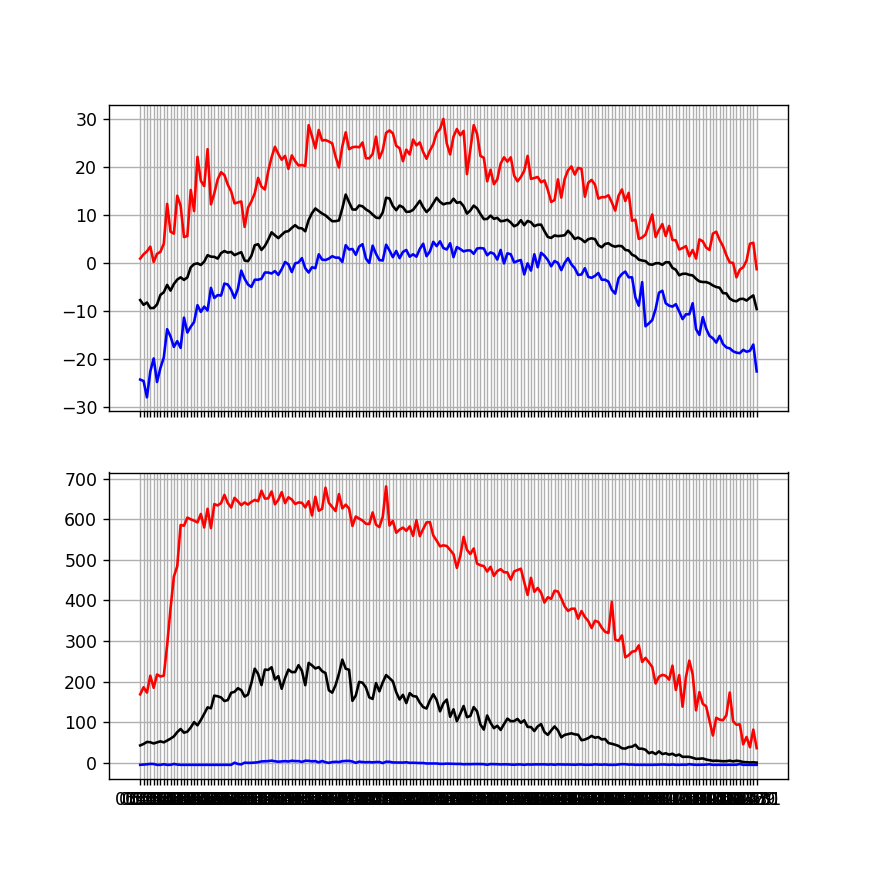

TypeError: 'builtin_function_or_method' object is not subscriptable

In [78]:
Data['MM-DD'] = Data.index.strftime('%m-%d')
Daily = Data.groupby('MM-DD').mean()
Dailymn = Data.groupby('MM-DD').min()
Dailymx = Data.groupby('MM-DD').max()
fig,ax = plt.subplots(2,sharex=True,figsize=(7,7))
from scipy import stats
# ax[0].errorbar(Daily.index,Daily['Air_Temp'],yerr=Dailys['Air_Temp'],color='r',ecolor='grey')
ax[0].plot(Daily.index,Daily['Air_Temp'],color='k')
ax[0].plot(Daily.index,Dailymn['Air_Temp'],color='b')
ax[0].plot(Daily.index,Dailymx['Air_Temp'],color='r')

# ax[0].plot(Daily.index,Daily['Air_Temp']+Dailys['Air_Temp']/(11**.5)*stats.t.ppf(1-0.025,11),color='r')#,ecolor='grey')
ax[0].grid()

ax[1].plot(Daily.index,Daily['Net_SW'],color='k')
ax[1].plot(Daily.index,Dailymn['Net_SW'],color='b')
ax[1].plot(Daily.index,Dailymx['Net_SW'],color='r')
ax[1].grid()

# Xt = ax[0].get_xticks()
# fig.canvas.draw()
# Xtl = ax[0].get_xticklabels()

P = np.arange[0,14,31,45,61,75,92,106,123,137,153,167,183]
ax[-1].set_xticks(P)
ax[-1].set_xlim(0,183)

fig.autofmt_xdate()

In [ ]:
Data.loc[((Data.index.day == 31)&(Data.index.month==10)),'Season']=np.nan
Data['GS']=np.nan

Max_NDVI = (Data.resample('Y').max()[['NDVI_interp']])
for i,row in Max_NDVI.iterrows():
    MxD = Data.loc[((Data.index.year==i.year)&(Data.NDVI_interp==row['NDVI_interp']))].index.dayofyear[0]
    Max_NDVI.loc[Max_NDVI.index.year==i,'Max_Day']=MxD
    Data.loc[((Data.index.year==i.year)&(Data.index.dayofyear<=MxD)
             &(Data.NDVI_interp>=0.25)),'GS']=1
    Data.loc[((Data.index.year==i.year)&(Data.index.dayofyear>=MxD)
             &(Data.NDVI_interp/row['NDVI_interp']>=0.9)),'GS']=1
    Data.loc[((Data.index.year==i.year)&(Data.index.dayofyear>=MxD)
             &(Data.NDVI_interp/row['NDVI_interp']<=0.9)&(Data['Season']==1)),'GS']=0.5

Data['Season_Days'] = Data['Season']*Data.index.dayofyear
Data['GS_Days'] = Data['GS']*Data.index.dayofyear
Data['Season_Dates']=pd.to_datetime(Data.index.year * 1000 + Data['Season_Days'], format='%Y%j')
Data['GS_Dates']=pd.to_datetime(Data.index.year * 1000 + Data['GS_Days'], format='%Y%j')
    
print(Data.resample('Y').sum()[['Season','GS']]/24)
print(Data.resample('Y').min()[['Season_Dates','GS_Dates']])
print(Data.resample('Y').max()[['Season_Dates','GS_Dates']])   
    
Study_Year = Data.loc[Data.index.year == 2019]

plt.figure()
plt.plot(Study_Year[['Season']],color='k',linewidth=4)
# plt.plot(Study_Year[['GS']]+1)
x2 = plt.twinx()
# x2.plot(Study_Year['NDVI_interp']*100,color='orange')
x2.plot(Study_Year['NDSI_interp'],color='b')
x2.plot(Study_Year['snow_cover'],color='r')
print(Study_Year['ndvi_FI_LCP'].dropna())

<IPython.core.display.Javascript object>


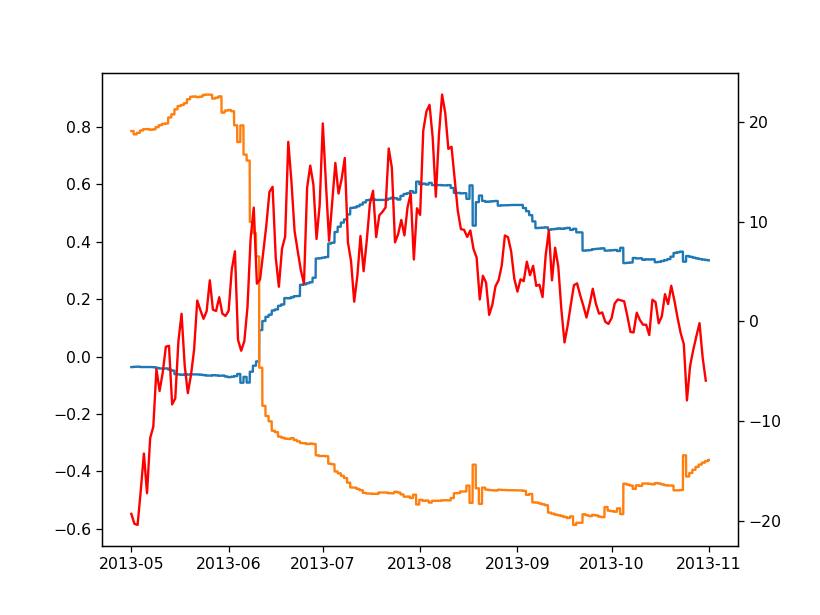

In [23]:
Study_Year = Data.loc[Data.index.year==2013]
# plt.figure()
# plt.scatter(Data['Full_Season'],Data['NDVI_FI_LCP'])
plt.plot(Study_Year['NDVI_FI_LCP'])
plt.plot(Study_Year['NDSI_FI_LCP'])
# # plt.plot(Study_Year['Snow'])
# # plt.plot(Study_Year['Season'])
ax2 = plt.twinx()
ax2.plot(Study_Year['Air_Temp'].resample('D').mean(),color='r')
# ax2.plot(Study_Year['snow_cover'],color='g')